<a href="https://colab.research.google.com/github/SindhuVarier/ttm/blob/main/predict_fog_ttm2_few_shot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Fog Prediction

TinyTimeMixers (TTMs) are compact pre-trained models for Multivariate Time-Series Forecasting, open-sourced by IBM Research. With less than 1 Million parameters, TTM introduces the notion of the first-ever "tiny" pre-trained models for Time-Series Forecasting. TTM outperforms several popular benchmarks demanding billions of parameters in zero-shot and few-shot forecasting and can easily be fine-tuned for multi-variate forecasts.

Customizing recipe https://github.com/ibm-granite-community/granite-timeseries-cookbook/blob/main/recipes/Time_Series/Few-shot_Finetuning_and_Evaluation.ipynb for for prediction in Bengaluru airports

## Setting Up

### Install the TSFM Library

The [granite-tsfm library](https://github.com/ibm-granite/granite-tsfm) provides utilities for working with Time Series Foundation Models (TSFM). Here we retrieve and install a tested version of the library.

In [1]:
# Install the tsfm library
! pip install "tsfm_public[notebooks] @ git+https://github.com/ibm-granite/granite-tsfm.git@v0.2.12" -U

  Cloning https://github.com/ibm-granite/granite-tsfm.git (to revision v0.2.12) to /tmp/pip-install-k27pg81w/tsfm-public_0af589d27fdd41c6b1b4d90a8aa92abb
  Running command git clone --filter=blob:none --quiet https://github.com/ibm-granite/granite-tsfm.git /tmp/pip-install-k27pg81w/tsfm-public_0af589d27fdd41c6b1b4d90a8aa92abb
  Running command git checkout -q 9484de7a81e9d202ca024ee7924b83a796661dca
  Resolved https://github.com/ibm-granite/granite-tsfm.git to commit 9484de7a81e9d202ca024ee7924b83a796661dca
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.2/144.2 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### Import Packages

From `tsfm_public`, we use the TinyTimeMixer model, forecasting pipeline, and plotting function.


In [3]:
import math
import os

import numpy as np
import pandas as pd
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed

from tsfm_public import (
    TimeSeriesForecastingPipeline,
    TimeSeriesPreprocessor,
    TinyTimeMixerForPrediction,
    TrackingCallback,
    count_parameters,
    get_datasets,
)
from tsfm_public.toolkit.time_series_preprocessor import prepare_data_splits
from tsfm_public.toolkit.visualization import plot_predictions

### Specify configuration variables

We provide the names of the timestamp column and the target column to be predicted. The context length (in time steps) is set to match the pretrained model.

In [52]:
timestamp_column = "Time"
target_columns = ['visibility_meters']

# TTM model branch
# Use main for 512-96 model
# Use "1024_96_v1" for 1024-96 model
TTM_MODEL_REVISION = "main"
context_length = 512 # the max context length for the 512-96 model
prediction_length = 96  # the max forecast length for the 512-96 model

# Return this percent of the original dataset when getting train/test splits.
fewshot_fraction = 0.10

# Output directory for writing evaluation results.
OUT_DIR = "/tmp/ttm_results"

## Preparing the Data

In [53]:
DATA_FILE_PATH = "vobl_nov29_cleaned.csv"

### Read in the data

We parse the CSV into a pandas dataframe, filling in any null values, and create a single window containing `context_length` time points. We ensure the timestamp column is a UTC datetime.

In [54]:
# Read in the data from the downloaded file.
input_df = pd.read_csv(DATA_FILE_PATH, parse_dates=[timestamp_column])

# Fill NA/NaN values by propagating the last valid value.
input_df = input_df.ffill()

# Show the last few rows of the dataset.
input_df.tail()

,dew_point,temperature,relative_humidity,wind_direction,wind_speed,solar_radiation,visibility_meters,Time,fog_category,pressure_altimeter_mb
26203,13.0,18.0,72.56,90.0,4.0,0.0,6002.8382,2024-02-29 03:00:00,NSR,1015.917
26204,13.0,18.0,72.56,90.0,4.0,0.0,6002.8382,2024-02-29 03:30:00,NSR,1015.917
26205,13.0,17.0,77.29,90.0,4.0,0.0,6002.8382,2024-02-29 04:00:00,NSR,1015.917
26206,13.0,17.0,77.29,90.0,3.0,0.0,6002.8382,2024-02-29 04:30:00,NSR,1015.917
26207,13.0,16.0,82.37,90.0,2.0,0.0,6002.8382,2024-02-29 05:00:00,NSR,1015.917


### Plot a segment of the target series

Here we inspect a preview of the target time series.

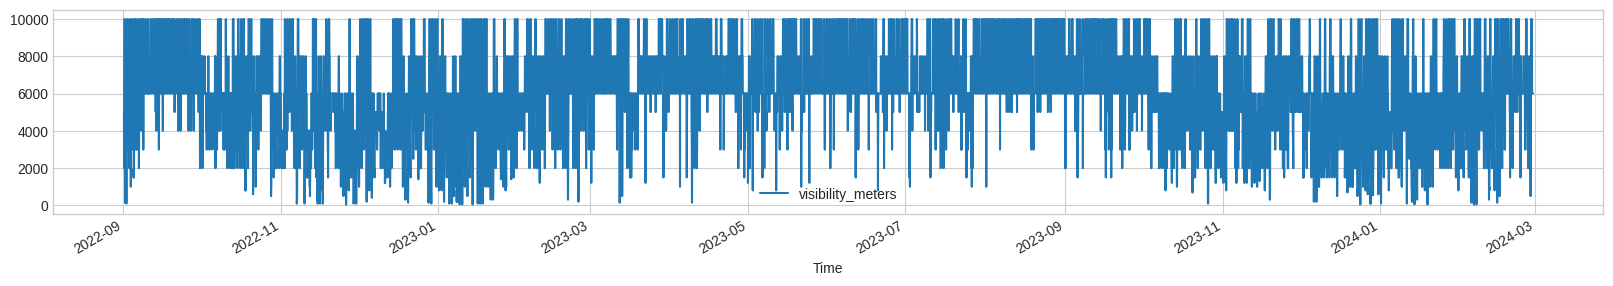

In [55]:
for target_column in target_columns:
    input_df.plot(x=timestamp_column, y=target_column, figsize=(20, 3))

## Preprocessing the Data

### Split the data into training and testing sets

We split the data into training, validation, and test sets. The training set is used to train the model, while the test set is used to evaluate its performance.

In [56]:
split_config = {"train": 0.6, "test": 0.2}

column_specifiers = {
    "timestamp_column": timestamp_column,
    "id_columns": [],
    "target_columns": target_columns,
    "control_columns": [
        "dew_point",
        "temperature",
        "relative_humidity",
        "wind_direction",
        "wind_speed",
        "solar_radiation",
        "pressure_altimeter_mb",
    ],
}

tsp = TimeSeriesPreprocessor(
    **column_specifiers,
    context_length=context_length,
    prediction_length=prediction_length,
    scaling=True,
    encode_categorical=False,
    scaler_type="standard",
)

train_df, valid_df, test_df = prepare_data_splits(input_df, context_length=context_length, split_config=split_config)

train_dataset, valid_dataset, test_dataset = get_datasets(
    tsp,
    input_df,
    split_config,
    fewshot_fraction=fewshot_fraction,
    fewshot_location="last",
)
print(f"Data lengths: train = {len(train_dataset)}, val = {len(valid_dataset)}, test = {len(test_dataset)}")

Data lengths: train = 1426, val = 5148, test = 5146


## Fine-tuning the Model

### Load the model for finetuning
The TTM model is hosted on [HuggingFace](https://huggingface.co/ibm-granite/granite-timeseries-ttm-v1), and is loaded into a `TinyTimeMixerForPrediction` model.

In [57]:
# Instantiate the model.
set_seed(42)
finetune_forecast_model = TinyTimeMixerForPrediction.from_pretrained(
    "ibm-granite/granite-timeseries-ttm-r2",  # Name of the model on HuggingFace.
    num_input_channels=tsp.num_input_channels,
    #prediction_channel_indices=tsp.prediction_channel_indices,
    #exogenous_channel_indices=tsp.exogenous_channel_indices,
    fcm_use_mixer=True,
    fcm_context_length=10,
    enable_forecast_channel_mixing=True,
    decoder_mode="mix_channel",
)

Some weights of TinyTimeMixerForPrediction were not initialized from the model checkpoint at ibm-granite/granite-timeseries-ttm-r2 and are newly initialized: ['decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.weight', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.1.channel_feature_mixer.mlp.fc1.bias', 'dec

### Freeze the TTM Backbone

During fine tuning we freeze the backbone and focus on tuning only the parameters in the decoder. This reduces the overall number of parameters being tuned while also maintaining the pre-trained backbone.

In [58]:
print(
    "Number of params before freezing backbone",
    count_parameters(finetune_forecast_model),
)

# Freeze the backbone of the model
for param in finetune_forecast_model.backbone.parameters():
    param.requires_grad = False

# Count params
print(
    "Number of params after freezing the backbone",
    count_parameters(finetune_forecast_model),
)

Number of params before freezing backbone 951872
Number of params after freezing the backbone 436288


# Set up a Trainer for Finetune Few-shot 10%

Configure a Trainer for use in fine-tuning and evaluating the model.

In [59]:
# Important parameters
learning_rate: float = 0.0001
num_epochs: int = 200
patience: int = 2
batch_size: int = 256

print(f"Using learning rate = {learning_rate}")
finetune_forecast_args = TrainingArguments(
    output_dir=os.path.join(OUT_DIR, "output"),
    overwrite_output_dir=True,
    learning_rate=learning_rate,
    num_train_epochs=num_epochs,
    do_eval=True,
    eval_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    dataloader_num_workers=8,
    report_to=None,
    save_strategy="epoch",
    logging_strategy="epoch",
    save_total_limit=1,
    logging_dir=os.path.join(OUT_DIR, "logs"),  # Make sure to specify a logging directory
    load_best_model_at_end=True,  # Load the best model when training ends
    metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
    greater_is_better=False,  # For loss
    use_cpu=finetune_forecast_model.device.type != "cuda",
)

# Create the early stopping callback
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=patience,  # Number of epochs with no improvement after which to stop
    early_stopping_threshold=0.00001,  # Minimum improvement required to consider as improvement
)
tracking_callback = TrackingCallback()

# Optimizer and scheduler
optimizer = AdamW(finetune_forecast_model.parameters(), lr=learning_rate)
scheduler = OneCycleLR(
    optimizer,
    learning_rate,
    epochs=num_epochs,
    steps_per_epoch=math.ceil(len(train_dataset) / (batch_size)),
)

finetune_forecast_trainer = Trainer(
    model=finetune_forecast_model,
    args=finetune_forecast_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    callbacks=[early_stopping_callback, tracking_callback],
    optimizers=(optimizer, scheduler),
)

Using learning rate = 0.0001


### Train the Model

Here we train the model on the fraction of data that was selected above (5% of the training data). This tunes only the weights in the decoder and output layers, as the other weights have been frozen.


In [60]:
# Fine tune
finetune_forecast_trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.363400,0.326232
2,0.367000,0.324870
3,0.353300,0.323626
4,0.357200,0.322335
5,0.347100,0.320956
6,0.343000,0.319233
7,0.337900,0.317251
8,0.331300,0.314924
9,0.336700,0.312281
10,0.324800,0.309229


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: T

Epoch,Training Loss,Validation Loss
1,0.363400,0.326232
2,0.367000,0.324870
3,0.353300,0.323626
4,0.357200,0.322335
5,0.347100,0.320956
6,0.343000,0.319233
7,0.337900,0.317251
8,0.331300,0.314924
9,0.336700,0.312281
10,0.324800,0.309229


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: T

[TrackingCallback] Mean Epoch Time = 66.73283429392453 seconds, Total Train Time = 8382.82738161087


TrainOutput(global_step=348, training_loss=0.2612368591215419, metrics={'train_runtime': 8382.9004, 'train_samples_per_second': 34.022, 'train_steps_per_second': 0.143, 'total_flos': 1934805304344576.0, 'train_loss': 0.2612368591215419, 'epoch': 58.0})

### Evaluate the Model

Evaluate the fine-tuned model on the test dataset.

In [62]:
# generate forecasts using the finetuned model
pipeline = TimeSeriesForecastingPipeline(
    finetune_forecast_model,
    device="cpu",  # Specify your local GPU or CPU.
    feature_extractor=tsp,
)

# Make a forecast on the target column given the input data.
finetune_forecast = pipeline(test_df)
finetune_forecast.head()

,Time,visibility_meters_prediction,visibility_meters
0,2023-11-12 00:30:00,"[4712.9472376258, 4587.57160585497, 4470.90156...","[5005.047460496349, 5005.047460496349, 4007.25..."
1,2023-11-12 01:00:00,"[4732.962896956206, 4522.218717448703, 4383.45...","[5005.047460496349, 4007.25660006376, 4007.256..."
2,2023-11-12 01:30:00,"[4658.60061872437, 4462.128759815733, 4416.673...","[4007.25660006376, 4007.25660006376, 2993.3724..."
3,2023-11-12 02:00:00,"[4131.2907582187545, 4160.295187858128, 4234.5...","[4007.25660006376, 2993.3724747089796, 2993.37..."
4,2023-11-12 02:30:00,"[4141.345584314655, 4252.834507225675, 4235.88...","[2993.3724747089796, 2993.3724747089796, 1995...."


In [66]:
# Define some standard metrics.
def custom_metric(actual, prediction, column_header="results"):
    """Simple function to compute MSE"""
    a = np.asarray(actual.tolist())
    p = np.asarray(prediction.tolist())

    mask = ~np.any(np.isnan(a), axis=1)

    mse = np.mean(np.square(a[mask, :] - p[mask, :]))
    mae = np.mean(np.abs(a[mask, :] - p[mask, :]))
    return pd.DataFrame(
        {
            column_header: {
                "mean_squared_error": mse,
                "root_mean_squared_error": np.sqrt(mse),
                "mean_absolute_error": mae,
            }
        }
    )


custom_metric(
    finetune_forecast["visibility_meters"],
    finetune_forecast["visibility_meters_prediction"],
    "fine-tune forecast (visibility_meters)",
)



,fine-tune forecast (visibility_meters)
mean_squared_error,2.410058e+06
root_mean_squared_error,1.552436e+03
mean_absolute_error,1.237073e+03


### Plot the Predictions vs. Actuals

Plot the predictions vs. actuals for some random samples of time intervals in test dataset.

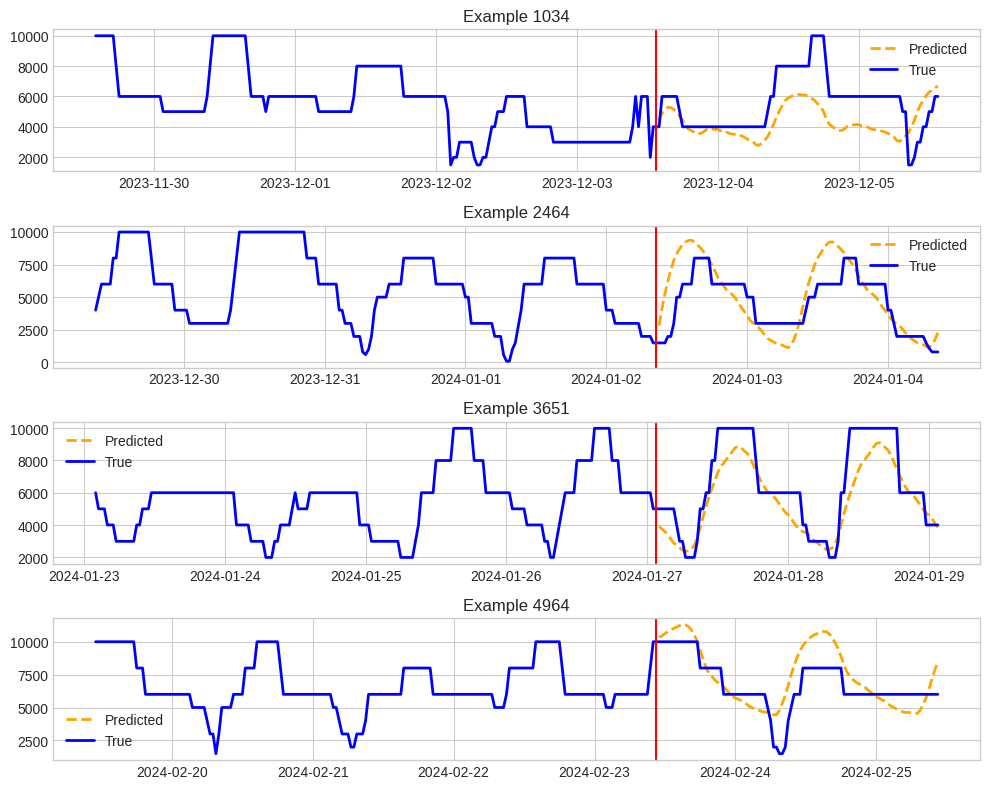

In [67]:
# plot
plot_predictions(
    input_df=test_df,
    predictions_df=finetune_forecast,
    timestamp_column=timestamp_column,
    freq=tsp.freq,
    plot_dir=None,
    plot_prefix="Test",
    channel="visibility_meters",
    plot_context=2 * prediction_length,
    indices=[1034,2464, 3651, 4964],
    num_plots=4,
)

## Making the Forecast

### Create a forecasting pipeline with the fine-tuned model

Set up the forecasting pipeline with the model, setting `frequency` given our knowledge of the sample frequency. We then make a forecast on the dataset.

In [68]:
historical_df = input_df.iloc[-context_length:].copy()

# Create a pipeline.
pipeline = TimeSeriesForecastingPipeline(
    finetune_forecast_trainer.model,
    feature_extractor=tsp,
    device="cpu",  # Specify your local GPU or CPU.
)

# Make a forecast on the target column given the input data.
future_forecast = pipeline(historical_df)
future_forecast.tail()

,Time,visibility_meters_prediction,visibility_meters
0,2024-02-29 05:00:00,"[6077.218942496975, 5900.564179651723, 5708.46...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."


### Plot predictions along with the historical data.

The predicted series picks up where the historical data ends, and we can see that it predicts a continuation of the cyclical pattern.

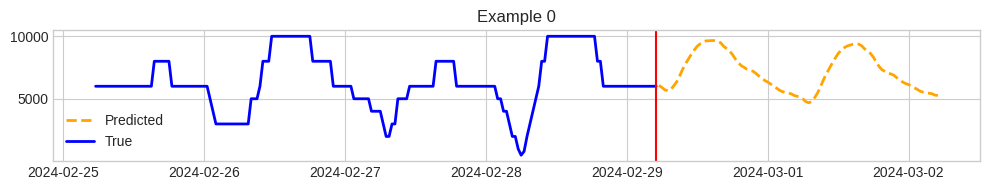

In [69]:
# Pre-cast the timestamp to avoid future dtype inference changes
historical_df[timestamp_column] = pd.to_datetime(historical_df[timestamp_column])

# Plot the historical data and predicted series.
plot_predictions(
    input_df=historical_df,
    predictions_df=future_forecast,
    freq=tsp.freq,
    timestamp_column=timestamp_column,
    channel=target_columns[0],
)


## Links
* Library: [Granite TSFM on Github](https://github.com/ibm-granite/granite-tsfm)
* Model: [TinyTimeMixer on HuggingFace](https://huggingface.co/ibm-granite/granite-timeseries-ttm-v1)
* Dataset: